In [1]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, size=5000, dim=40, random_offset=0):
        super(MyDataset, self).__init__()
        self.size = size
        self.dim = dim
        self.random_offset = random_offset

    def __getitem__(self, index):
        if index >= len(self):
            raise IndexError("{} index out of range".format(self.__class__.__name__))

        rng_state = torch.get_rng_state()
        torch.manual_seed(index + self.random_offset)

        while True:
            img = torch.zeros(self.dim, self.dim)
            dx = torch.randint(-10,10,(1,),dtype=torch.float)
            dy = torch.randint(-10,10,(1,),dtype=torch.float)
            c = torch.randint(-20,20,(1,), dtype=torch.float)

            params = torch.cat((dy/dx, c))
            xy = torch.randint(0,img.shape[1], (20, 2), dtype=torch.float)
            xy[:,1] = xy[:,0] * params[0] + params[1]

            xy.round_()
            xy = xy[ xy[:,1] > 0 ]
            xy = xy[ xy[:,1] < self.dim ]
            xy = xy[ xy[:,0] < self.dim ]

            for i in range(xy.shape[0]):
                x, y = xy[i][0], self.dim - xy[i][1]
                img[int(y), int(x)]=1
            if img.sum() > 2:
                break
                
        torch.set_rng_state(rng_state)
        return img.unsqueeze(0), params

    def __len__(self):
        return self.size

train_data = MyDataset()
val_data = MyDataset(size=500, random_offset=33333)
test_data = MyDataset(size=500, random_offset=99999)

# automatically reload external modules if they change
%load_ext autoreload
%autoreload 2

import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchbearer
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchbearer import Trial

# create data loaders
trainloader = DataLoader(train_data, batch_size=128, shuffle=True)
testloader = DataLoader(test_data, batch_size=128, shuffle=True)

In [20]:
class BetterCNN(nn.Module):
    def __init__(self):
        super(BetterCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 48, (3, 3), padding=1, stride=1)
        self.conv2 = nn.Conv2d(48, 48, (3, 3), padding=1, stride=1)
        self.pool = nn.AdaptiveAvgPool2d((1, 20 * 20))
        self.fc1 = nn.Linear(48 * 1 * (20 * 20), 128)
        self.fc2 = nn.Linear(128, 2)
            
    def forward(self, x):
        print("x=")
        print(x)
        print(x.shape) #torch.Size([128, 1, 40, 40])
        idxx = torch.repeat_interleave(torch.arange(-20,20, dtype=torch.float).unsqueeze(0)/40.0,
                                      repeats=40,dim=0).to(x.device)
        print(idxx)
        idxy = idxx.clone().t()
        print(idxy)
        idx = torch.stack([idxx,idxy]).unsqueeze(0)
        print(idx)
        idx = torch.repeat_interleave(idx, repeats=x.shape[0], dim=0)
        print(idx)
        x = torch.cat([x,idx], dim=1)
        print("x=")
        print(x)
        print(x.shape) #torch.Size([128, 3, 40, 40])
        
        
        # input: 128 x 1 x 40 x 40 
        out = self.conv1(x)
        out = F.relu(out)
        # conv1 output: 128 x 48 x 40 x 40 
        out = self.conv2(out)
        out = F.relu(out)
        # conv2 output: 128 x 48 x 40 x 40 
        out = self.pool(out)
        # print(out.shape)
        out = out.view(out.shape[0], -1)
        # print(out.shape)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        # print(out.shape,"\n\n")
        return out

In [21]:


num_epochs = 100
device = "cuda:0" if torch.cuda.is_available() else "cpu"
#model = SimpleCNN2().to(device)
model = BetterCNN().to(device)

loss_function = nn.MSELoss(reduction='sum')
optimiser = optim.Adam(model.parameters())

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    train_loss = 0.0
    model.train()
    for data in trainloader:

        inputs, labels = data[0].to(device), data[1].to(device)
        optimiser.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimiser.step()

        train_loss += loss.cpu().detach().numpy()
    train_loss = train_loss / (len(trainloader) * 128) 
    train_losses.append(train_loss)

    val_loss = 0.0 
    model.eval()
    for data in testloader:

        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        val_loss += loss.cpu().detach().numpy()
    val_loss = val_loss / (len(testloader) * 128)
    val_losses.append(val_loss)

    torch.cuda.empty_cache()
    
    print("Epoch %d, train_loss %4.2f, val_loss %4.2f" % (epoch, train_loss, val_loss))
print("Finished Training")



x=
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ...,

tensor([[[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
          [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
          [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
          ...,
          [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
          [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
          [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750]],

         [[-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.4750, -0.4750, -

tensor([[[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
          [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
          [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
          ...,
          [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
          [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
          [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750]],

         [[-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.4750, -0.4750, -

tensor([[[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
          [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
          [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
          ...,
          [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
          [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
          [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750]],

         [[-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.4750, -0.4750, -

       device='cuda:0')
x=
tensor([[[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
          [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
          [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
          ...,
          [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
          [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
          [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750]],

         [[-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
   

tensor([[[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
          [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
          [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
          ...,
          [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
          [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
          [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750]],

         [[-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.4750, -0.4750, -

          [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')
torch.Size([128, 1, 40, 40])
tensor([[-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
        [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
        [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
        ...,
        [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
        [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
        [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750]],
       device='cuda:0')
tensor([[-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
        [-0.4750, -0.4750, -0.4750,  ..., -0.4750, -0.4750, -0.4750],
        [-0.4500, -0.4500, -0.4500,  ..., -0.4500, -0.4500, -0.4500],
        ...,
        [ 0.4250,  0.4250,  0.4250,  ...,  0.4250,  0.4250,  0.4250],
        [ 0.4500,  0.4500,  0.4500,  ...,  0.4500,  0.4500,  0.4500],
        [ 0.4750,  0.4750,  0.4750,  ...,  0.4750,  0.4750,  0.4750]],
       device='cu

x=
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 1.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ...,

tensor([[[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  1.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
          [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
          [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
          ...,
          [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
          [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
          [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750]],

         [[-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.4750, -0.4750, -

          [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')
torch.Size([128, 1, 40, 40])
tensor([[-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
        [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
        [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
        ...,
        [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
        [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
        [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750]],
       device='cuda:0')
tensor([[-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
        [-0.4750, -0.4750, -0.4750,  ..., -0.4750, -0.4750, -0.4750],
        [-0.4500, -0.4500, -0.4500,  ..., -0.4500, -0.4500, -0.4500],
        ...,
        [ 0.4250,  0.4250,  0.4250,  ...,  0.4250,  0.4250,  0.4250],
        [ 0.4500,  0.4500,  0.4500,  ...,  0.4500,  0.4500,  0.4500],
        [ 0.4750,  0.4750,  0.4750,  ...,  0.4750,  0.4750,  0.4750]],
       device='cu

          [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')
torch.Size([128, 1, 40, 40])
tensor([[-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
        [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
        [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
        ...,
        [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
        [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
        [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750]],
       device='cuda:0')
tensor([[-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
        [-0.4750, -0.4750, -0.4750,  ..., -0.4750, -0.4750, -0.4750],
        [-0.4500, -0.4500, -0.4500,  ..., -0.4500, -0.4500, -0.4500],
        ...,
        [ 0.4250,  0.4250,  0.4250,  ...,  0.4250,  0.4250,  0.4250],
        [ 0.4500,  0.4500,  0.4500,  ...,  0.4500,  0.4500,  0.4500],
        [ 0.4750,  0.4750,  0.4750,  ...,  0.4750,  0.4750,  0.4750]],
       device='cu

KeyboardInterrupt: 

In [ ]:
print(train_data[0])

In [ ]:
# build the model
model = SimpleCNN()

# define the loss function and the optimiser
loss_function = nn.CrossEntropyLoss()
#loss_function = nn.MSELoss()
optimiser = optim.Adam(model.parameters())

device = "cuda:0" if torch.cuda.is_available() else "cpu"
trial = Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
trial.with_generators(trainloader, test_generator=testloader)
trial.run(epochs=100)
results = trial.evaluate(data_key=torchbearer.TEST_DATA)
print(results)


In [35]:
x = train_data[0][0]
print(x.shape)
idxx = torch.repeat_interleave(torch.arange(-20,20, dtype=torch.float).unsqueeze(0)/40.0,
                              repeats=40,dim=0)
idxy = idxx.clone().t()
idx = torch.stack([idxx,idxy]).unsqueeze(0)
idx = torch.repeat_interleave(idx, repeats=x.shape[0], dim=0)
print(idx.shape)
x = torch.cat([x,idx], dim=1)
print(idx)

torch.Size([1, 40, 40])
torch.Size([1, 2, 40, 40])


RuntimeError: invalid argument 0: Tensors must have same number of dimensions: got 3 and 4 at C:\w\1\s\tmp_conda_3.7_100118\conda\conda-bld\pytorch_1579082551706\work\aten\src\TH/generic/THTensor.cpp:603

In [41]:
torch.set_printoptions(profile="full")
print(train_data[3][0])
torch.set_printoptions(profile="default")

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.,

torch.Size([40, 40])


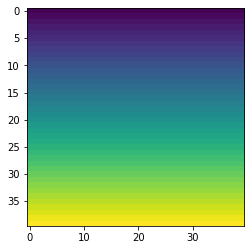

In [37]:


import matplotlib.pyplot as plt 

for i in range(1):
    data, label = train_data.__getitem__(i)
    data = torch.repeat_interleave(torch.arange(-20,20, dtype=torch.float).unsqueeze(0)/40.0,
                              repeats=40,dim=0)
    data = data.t()
    print(data.shape)

    data = data.squeeze()

    plt.figure()
    plt.imshow(data)
    plt.show()
